# **CT216 - Project**
# Kalman Filter

**Model for Airplane movement in XY Direction.**

1) Import libraries.    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

2) Write down initial conditions.

In [2]:
itr = 50

# Initial Observations
ini_Vx = 25 # m/s
ini_Vy = 15 # m/s
ini_X = 150 # m
ini_Y = 280 # m
ini_observation = np.array([ini_X, ini_Y, ini_Vx, ini_Vy])

# Assuming accelaration is constant
ini_Ax = 2 # m/s²
ini_Ay = 1 # m/s²
ini_accelaration = np.array([ini_Ax, ini_Ay])

# Process errors in Process Covariance Matrix (Error due to machine or any other process in calculations)
del_PX = 20 # m
del_PY = 15 # m
del_PVx = 5 # m/s
del_PVy = 3.5 # m/s
process_errors = np.array([del_PX, del_PY, del_PVx, del_PVy])

# Observation errors 
del_X = 25 # m
del_Y = 18 # m
del_Vx = 6 # m/s
del_Vy = 5 # m/s
observation_errors = np.array([del_X, del_Y, del_Vx, del_Vy])

# Time difference between each ebservation
del_T = 1 # s

3) Write down Observed State matrix.

In [3]:
X = np.array([ini_observation])

# Generate Position Vectors based on velocity vector
for i in range(1,itr+1):
    perfVx = ini_Vx + ini_Ax*i*del_T
    perfVy = ini_Vy + ini_Ay*i*del_T
    perfX = X[i-1][0] + perfVx
    perfY = X[i-1][1] + perfVy
    
    random_Vx_err = np.random.uniform(-del_Vx, del_Vx, size=1)
    random_Vy_err = np.random.uniform(-del_Vy, del_Vy, size=1)
    random_X_err = np.random.uniform(-del_X, del_X, size=1)
    random_Y_err = np.random.uniform(-del_Y, del_Y, size=1)
        
    X = np.append(X, [[perfX+random_X_err[0], perfY+random_Y_err[0], perfVx+random_Vx_err[0], perfVy+random_Vy_err[0]]], axis=0)
    # X = np.append(X, [[curr_X, curr_Y, random_Vx[1], random_Vy[1]]], axis=0)
    
np.array(X)

array([[ 150.        ,  280.        ,   25.        ,   15.        ],
       [ 176.46731853,  283.30645723,   22.80245524,   18.68758386],
       [ 190.77479315,  317.51478844,   25.96608685,   15.02927798],
       [ 238.22543054,  323.0120252 ,   36.43105142,   14.39332045],
       [ 263.30131044,  353.69855484,   29.67540786,   15.87244641],
       [ 305.32149083,  372.48558561,   34.80295614,   15.78485288],
       [ 319.09978159,  376.39832095,   40.40963308,   24.78664723],
       [ 357.16724248,  382.01405718,   41.5972169 ,   17.17156081],
       [ 413.3629775 ,  412.91310974,   36.0168935 ,   24.63654037],
       [ 453.70155986,  441.39346208,   41.56391801,   24.79521061],
       [ 493.36264785,  463.57605763,   45.37796926,   22.09172049],
       [ 553.67764713,  499.43578576,   41.86397119,   25.15892373],
       [ 611.18886917,  520.20782723,   47.98910758,   23.35224005],
       [ 641.16291785,  546.26558568,   56.1380473 ,   28.18356952],
       [ 698.04479044,  573.284998

4) Generate A and B matrix according to shape of state matrix.

In [4]:
# A matrix
A = np.array([[1, 0, del_T, 0],
              [0, 1, 0, del_T],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

# B matrix
B = np.array([[(del_T**2)*0.5, 0],
              [0, (del_T**2)*0.5],
              [del_T, 0],
              [0, del_T]])

# print(A, B)

5. Function to generate covariance matrix.

In [5]:
def generate_Covariance(dim, errors):
    cov_mat = errors**2 * np.identity(dim)
    # print(cov_mat)
    return cov_mat

6. Calculate Measurement Noice Covariance matrix R, Process Noice Covariance matrix Q and State Covariance Matrix P.

In [6]:
# R = Measurement Covariance Matrix --> Error in the measurement
# Needs to generate only once in whole process
R = generate_Covariance(observation_errors.shape[0], observation_errors)
# print(R)

# Q = Process Covariance Matrix --> Error in the process
Q = generate_Covariance(process_errors.shape[0], process_errors)
print(process_errors)
print(Q)

# P = State Covariance Matrix --> Error in the estimate 
P = generate_Covariance(process_errors.shape[0], process_errors)

# Let's keep P and Q keep same in first iteration
# Q will be constant in every iteration, but P will change

[20.  15.   5.   3.5]
[[400.     0.     0.     0.  ]
 [  0.   225.     0.     0.  ]
 [  0.     0.    25.     0.  ]
 [  0.     0.     0.    12.25]]


7. Define function to calculate Normal Distribution

In [7]:
def Normal_Distribution(prev_state, mean, variance):
    ans = []
    
    for ix in range(variance.shape[0]):
        for iy in range(variance.shape[1]):
            if ix==iy:
                value = (1 / (np.sqrt(variance[ix][iy]*2*np.pi))) * np.exp(-0.5 * (np.square(prev_state[ix]-mean)/variance[ix][iy]))
                ans.append(value)
    
    return np.array(ans)

8) Function to predict state.

In [8]:
Uk = np.array([ini_Ax, ini_Ay])

# Assuming their is no noice
def predict_state(A, B, prev_state, W):
    curr_state = np.matmul(A, prev_state) + np.matmul(B, Uk) + W
    curr_state = np.array(curr_state)
    
    return curr_state

9. Function to generate Predicted Process Covariance Matrix.

In [9]:
# This function will run only  one time, on 1st iteration
def predict_process_covariance(first_PC, A, Q):
    predicted_P = np.matmul(A, np.matmul(first_PC, np.transpose(A))) + Q
    
    # Make predicted_P a diagonal Matrix
    predicted_P = np.multiply(predicted_P, np.identity(predicted_P.shape[0]))
    return predicted_P

10. Update Process Covariance Matrix.

In [10]:
def update_proccess_covariance(prev_PC, K):
    updated_PC = (np.identity(K.shape[0]) - K) * prev_PC
    
    return updated_PC

11. Function to calculate Kalman Gain.

In [11]:
def Kalman_Gain(predicted_P, R):
    if predicted_P.shape == R.shape:
        K = np.divide(predicted_P, predicted_P + R, where = predicted_P!=0)
    
    # Make K a diagonal Matrix
    K = np.multiply(K, np.identity(K.shape[0]))
    return K

12. Function to calculate new observation Y.

In [12]:
def new_Observation(observed_state, V):
    Y = observed_state + V
    return Y

13. Function to calculate next state based on Kalman Gain.

In [13]:
def generate_State(curr_state_equ, K, new_Obs):
    predicted_state = curr_state_equ + np.matmul(K, new_Obs - curr_state_equ)
    return predicted_state

14. Final Loop for itr Iterations.

In [14]:
final_prediction = np.array([X[0]])
final_observation = np.array([])
final_calculated = np.array([])

for curr_itr in range(itr):

    # Calculating W and V for current iteration
    W = Normal_Distribution(X[curr_itr], 0, Q)
    V = Normal_Distribution(X[curr_itr], 0, R)

    if curr_itr == 0:
        # Calculating State
        curr_state = predict_state(A, B, X[curr_itr], W)
        final_calculated = np.append(final_calculated, curr_state)
        curr_P = predict_process_covariance(P, A, Q)

        # Calculate Kalman Gain
        curr_KGain = Kalman_Gain(curr_P, R)

        # Calculate new observation Y
        new_Obs = new_Observation(X[curr_itr], V)
        final_observation = np.append(final_observation, new_Obs)

        # Calculate new Predicted state based on Kalman Gain calculations
        predicted_state = generate_State(curr_state, curr_KGain, new_Obs)
        # final_prediction = np.append(final_prediction, predicted_state)

        # Calculate new Process Covariance Matrix
        updated_PC = update_proccess_covariance(curr_P, curr_KGain)

    else:
        curr_state = predict_state(A, B, prev_state, W)
        final_calculated = np.append(final_calculated, curr_state)

        curr_P = predict_process_covariance(prev_PC, A, Q)
        curr_KGain = Kalman_Gain(curr_P, R)
        
        # new_Obs = new_Observation(X[curr_itr+1], V)
        new_Obs = X[curr_itr]
        final_observation = np.append(final_observation, new_Obs)

        predicted_state = generate_State(curr_state, curr_KGain, new_Obs)
        final_prediction = np.append(final_prediction, predicted_state)
        
        updated_PC = update_proccess_covariance(curr_P, curr_KGain)

    prev_state = predicted_state
    prev_PC = updated_PC

# print(final_calculated)


In [15]:
finali = []
for i in range(int(final_prediction.shape[0]/4)):
    tempi = []
    for j in range( 4*i , 4*i + 4 ):
        tempi.append(final_prediction[j])
    finali.append(tempi)

    
finali = np.array(finali)
print(finali)
# print(np.array(finali))

[[ 150.          280.           25.           15.        ]
 [ 181.62987463  291.5313609    25.01472132   17.58826689]
 [ 198.35212743  314.08479465   26.43110375   16.82113396]
 [ 232.62812719  326.66422524   32.87709005   16.11886234]
 [ 264.7431174   349.16548196   31.98706486   16.49985708]
 [ 301.9050403   369.73470952   34.44034404   16.64812827]
 [ 327.3112984   380.96173339   38.64551063   21.1933756 ]
 [ 361.57309603  390.99814356   41.17423662   19.69935897]
 [ 409.03539546  412.16638575   39.19793447   22.65470765]
 [ 451.6906043   438.75044239   41.40125866   24.22112327]
 [ 493.6908358   463.53057714   44.49943122   23.66694699]
 [ 547.15750849  494.3266663    43.92417564   24.9112807 ]
 [ 602.58955759  520.00331022   47.07136005   24.64036719]
 [ 645.43755378  545.77727118   52.99729741   26.90341481]
 [ 698.67039623  573.23959612   51.34252404   30.00508146]
 [ 760.286831    599.22039788   55.69230851   32.04747001]
 [ 812.27215562  619.1590056    56.58062837   30.3532614

In [16]:
final0 = []
for i in range(int(final_observation.shape[0]/4)):
    temp0 = []
    for j in range(4*i, 4*i + 4):
        temp0.append(final_observation[j])
    final0.append(temp0)
    

final0 = np.array(final0)
print(final0)

[[ 150.          280.           25.00001129   15.00088637]
 [ 176.46731853  283.30645723   22.80245524   18.68758386]
 [ 190.77479315  317.51478844   25.96608685   15.02927798]
 [ 238.22543054  323.0120252    36.43105142   14.39332045]
 [ 263.30131044  353.69855484   29.67540786   15.87244641]
 [ 305.32149083  372.48558561   34.80295614   15.78485288]
 [ 319.09978159  376.39832095   40.40963308   24.78664723]
 [ 357.16724248  382.01405718   41.5972169    17.17156081]
 [ 413.3629775   412.91310974   36.0168935    24.63654037]
 [ 453.70155986  441.39346208   41.56391801   24.79521061]
 [ 493.36264785  463.57605763   45.37796926   22.09172049]
 [ 553.67764713  499.43578576   41.86397119   25.15892373]
 [ 611.18886917  520.20782723   47.98910758   23.35224005]
 [ 641.16291785  546.26558568   56.1380473    28.18356952]
 [ 698.04479044  573.28499851   48.41870535   32.1352137 ]
 [ 767.87630649  595.73350849   57.57213608   33.10397698]
 [ 808.42010874  609.44128011   55.69128427   27.6225617

In [17]:
finalc = []
for i in range(int(final_calculated.shape[0]/4)):
    tempc = []
    for j in range(4*i, 4*(i+1)):
        tempc.append(final_calculated[j])
    finalc.append(tempc)
    
finalc = np.array(finalc)
print(finalc)

[[ 176.          295.5          27.0000003    16.00001171]
 [ 188.04411254  302.39277652   27.83721842   16.5054952 ]
 [ 207.64459596  309.61962779   27.01472143   18.58827819]
 [ 225.78323118  331.40592861   28.43110375   17.8211582 ]
 [ 266.50521724  343.28308758   34.87709005   17.11886624]
 [ 297.73018227  366.16533904   33.98706486   17.49986145]
 [ 337.34538434  386.88283779   36.44034404   17.64812827]
 [ 366.95680903  402.655109     40.64551063   22.19337628]
 [ 403.74733265  411.19750253   43.17423662   20.69935897]
 [ 449.23332993  435.3210934    41.19793447   23.65470765]
 [ 494.09186297  463.47156566   43.40125866   25.22112327]
 [ 539.19026702  487.69752413   46.49943122   24.66694699]
 [ 592.08168414  519.737947     45.92417564   25.9112807 ]
 [ 650.66091764  545.14367741   49.07136005   25.64036719]
 [ 699.43485119  573.18068599   54.99729741   27.90341481]
 [ 751.01292027  603.74467758   53.34252404   31.00508146]
 [ 816.97913951  631.76786789   57.69230851   33.0474700

Text(0, 0.5, 'Position Y (in m)')

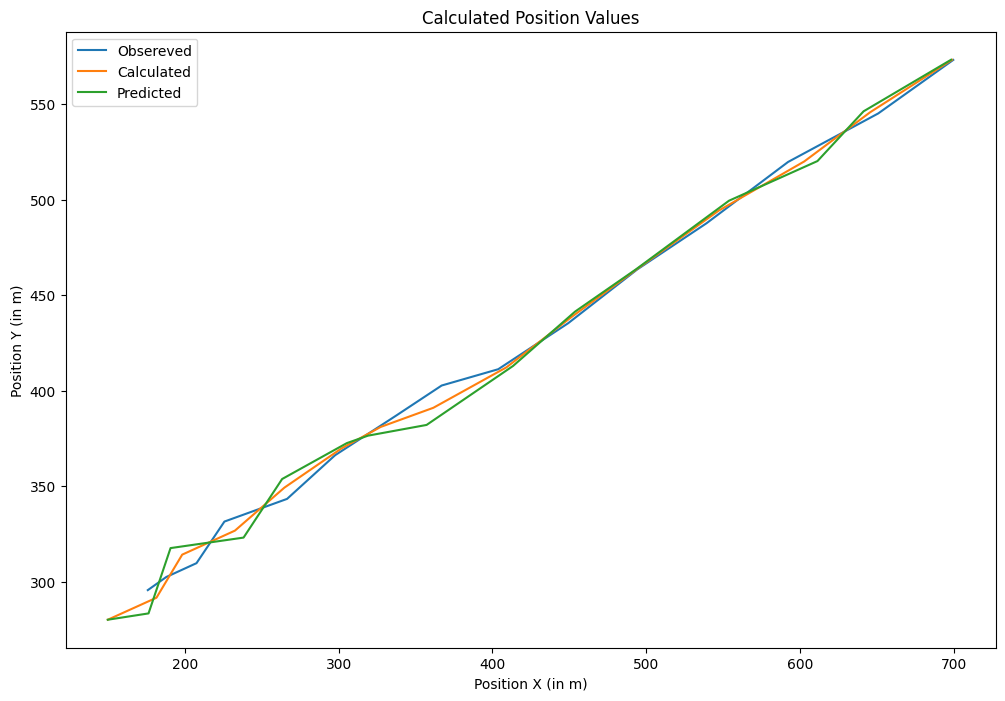

In [18]:
plt.figure(figsize=(12,8))
plt.plot(finalc[:15,0], finalc[:15,1], label="Obsereved")
plt.plot(finali[:15,0], finali[:15,1], label="Calculated")
plt.plot(final0[:15,0], final0[:15,1], label="Predicted")
plt.legend()
plt.title("Calculated Position Values")
plt.xlabel("Position X (in m)")
plt.ylabel("Position Y (in m)")

# plt.xticks(finalc[18:23,0])
# plt.show()